# ch 16_2 Stationary, Non Stationary

이전 챕터에서 시계열 데이터의 정상성과 비정상성에 대해서 배워보았습니다. 그리고 정상성을 갖춘 데이터는 시간의 흐름에 따라서 평균과 분산이 변하지 않는다고 했습니다. 이번 챕터에서는 데이터가 정상성인지 비정상성인지 테스트 할 수 있는 방법에 대해서 배우고, 비정상 데이터를 차분을 이용해서 정상 데이터로 변환해보겠습니다.

## 데이터 준비

<Axes: xlabel='Month'>

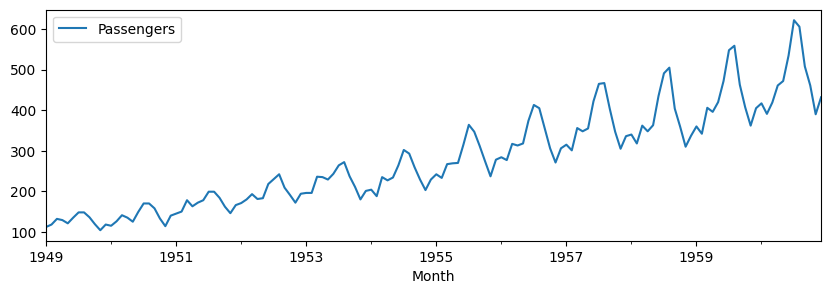

In [2]:
import pandas as pd

df = pd.read_csv("./data/AirPassengers.csv", index_col="Month", parse_dates=True)
df.plot(figsize=(10, 3))

## Stationary Test

육안으로 정상인지, 비정상인지를 판단하는 데에는 한계가 있습니다. 시계열 데이터가 stationary인지 체크하는 기법은 크게 2가지 통계적 가설 검정 기법이 사용됩니다.

### ADF Test
Augmented Dickey Fuller test의 약자로 시계열 데이터가 단위근(unit root) 문제를 포함하는지 여부를 확인하여 정상성을 검사합니다. 만일 통과하지 못했다면 

- 귀무 가설: 시계열 데이터에 단위근이 존재하며, 비정상성을 가지고 있다. (기각해야 정상성)
- 대립 가설: 시계열 데이터가 정상성을 가지며, 단위근이 존재하지 않는다.

In [3]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df["Passengers"])

In [6]:
adf_p_value = adf_result[1]
print(f"ADF test p-value: {adf_p_value} stationary: {adf_p_value < 0.05}")

ADF test p-value: 0.9918802434376409 stationary: False


### KPSS Test 

Kwiatkowski-Phillips-Schmidt-Shin test의 약자로  시계열 데이터의 트렌드 정상성을 검사하는 데 사용합니다.

- 귀무 가설: 시계열 데이터가 정상성을 가지며, 트렌드를 가지지 않는다. (기각하지 못해야 정상성)
- 대립 가설: 시계열 데이터가 트렌드 정상성을 가지지 않으며, 추세를 따라 움직인다.

In [7]:
from statsmodels.tsa.stattools import kpss

kpss_result = kpss(df["Passengers"])

/Users/user/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [10]:
kpss_p_value = kpss_result[1]
print(f"KPSS test p-value: {kpss_p_value} stationary: {kpss_p_value > 0.05}")

KPSS test p-value: 0.01 stationary: False


이를 함수로 정리해보겠습니다.

In [11]:
def stationary_test(data):
    adf_result = adfuller(data)
    adf_p_value = adf_result[1]
    kpss_result = kpss(data)
    kpss_p_value = kpss_result[1]
    print(f"ADF test p-value: {adf_p_value} stationary: {adf_p_value < 0.05}")
    print(f"KPSS test p-value: {kpss_p_value} stationary: {kpss_p_value > 0.05}")

In [12]:
stationary_test(df["Passengers"])

ADF test p-value: 0.9918802434376409 stationary: False
KPSS test p-value: 0.01 stationary: False


/Users/user/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


### 검사 결과 정리

두 검사 결과가 일치할 때는 상관없지만, 일치하지 않을 경우 취할 수 있는 대처 방법들을 정리하였습니다.

|  | ADF - stationary | ADF - non-stationary |
| --- | --- | --- |
| KPSS - stationary | stationary | trend stationary, remove the trend |
| KPSS - non stationary | difference stationary, use defferencing | non-stationary |

## 차분을 이용한 정상성 확보

차분을 적용하는 것은 가장 기본적이면서도 많이 사용되는 정상성 확보 기법입니다. 특히 앞으로 배울 가장 기본적인 시계열 예측 모델인 ARIMA 모델이 사용하는 기법입니다.

먼저 원본 데이터가 정상성을 확보했는지 테스트를 해봅니다. 만약 비정상성이라면 1차 차분을 적용하고 정상성이 확보되는지 확인합니다. 그래도 비정상성이라면 2차 차분을 적용합니다.

### 1차 차분 후 정상성 테스트

1차 차분을 적용한 다음 플랏을 그려보면, 시간의 흐름에 평균은 유지되는 것 같으나 분산은 커지는 것을 확인할 수 있습니다. 즉, 여전히 비정상성 데이터라는 것을 알 수 있습니다.

In [13]:
df["1D diff"] = df["Passengers"].diff()
df["2D diff"] = df["1D diff"].diff()

<Axes: xlabel='Month'>

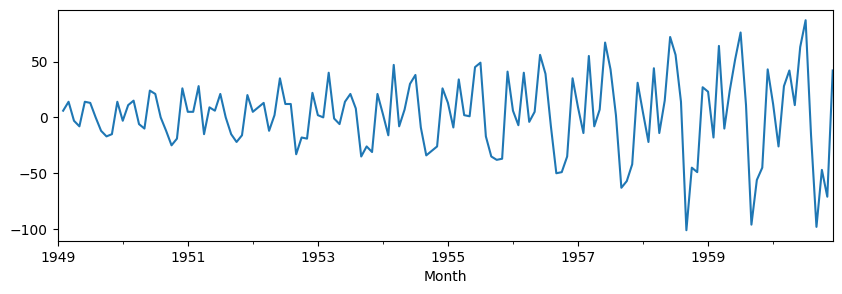

In [14]:
df["1D diff"].plot(figsize=(10, 3))

stationary test를 적용해보면 adf test는 통과하지 못하였으나, kpss test는 통과하였습니다. 이는 추가적인 차분으로 해결할 수 있습니다.

In [18]:
stationary_test(df["1D diff"].dropna())

ADF test p-value: 0.054213290283828236 stationary: False
KPSS test p-value: 0.1 stationary: True


/Users/user/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


### 2차 차분 적용 후 정상성 테스트

<Axes: xlabel='Month'>

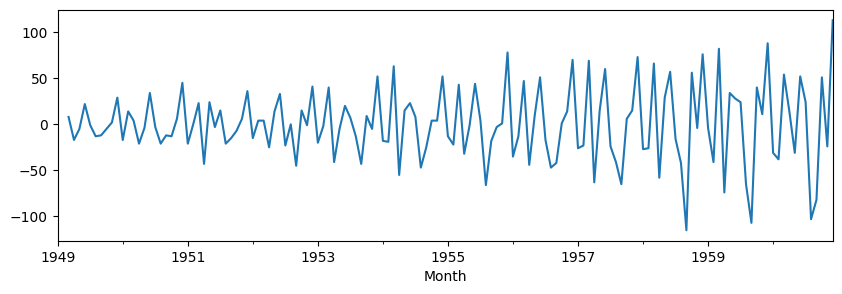

In [19]:
df["2D diff"].plot(figsize=(10, 3))

2차 차분을 적용한 다음 정상성 테스트를 하면 모두 통과하는 것을 확인할 수 있습니다. 즉, 차분의 차원을 2로 적용할 경우, 시계열 데이터의 정상성을 확보할 수 있습니다.

In [20]:
stationary_test(df["2D diff"].dropna())

ADF test p-value: 2.732891850013928e-29 stationary: True
KPSS test p-value: 0.1 stationary: True


/Users/user/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


## 시계열 데이터 트렌드 제거

잘 사용되지는 않습니다만 시계열 데이터의 정상성을 확보하기 위해서 트렌드와 계절성을 각각 제거해주는 기법들을 사용할 수 있습니다. 가볍게 한번 알아보겠습니다.

1. timeseries decompose: 시계열 분해에서 얻은 추세 성분을 뺍니다.
2. linear regression: 시계열에서 가장 잘 맞는 선을 뺍니다. 가장 잘 맞는 선은 시간 단계를 예측자로 사용하는 선형 회귀 모델에서 얻을 수 있습니다. 더 복잡한 추세의 경우 모델에서 이차 항(x^2)을 사용할 수 있습니다.
3. mean: 평균을 뺍니다.

### Timeseries Decompose

시계열 데이터를 분해한 다음, 추세 성분을 빼줍니다.

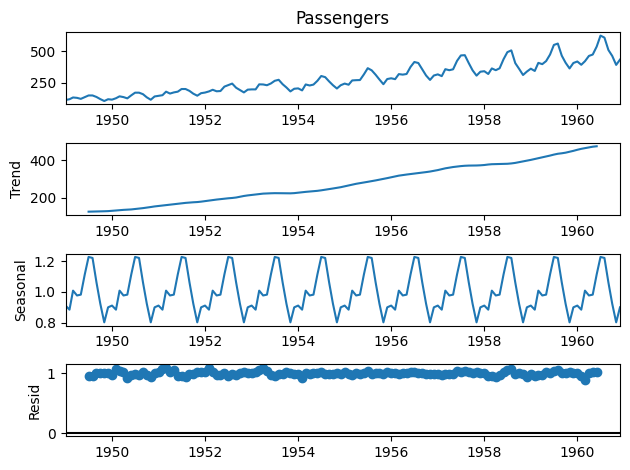

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_mul = seasonal_decompose(df["Passengers"], model="multiplicative")
result_mul.plot();

In [26]:
df["detrend - decompose"] = df["Passengers"] / result_mul.trend

<Axes: xlabel='Month'>

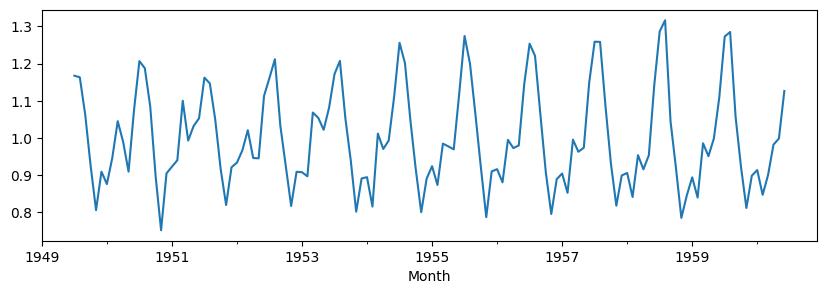

In [28]:
df["detrend - decompose"].plot(figsize=(10, 3))

육안으로 보기에는 시간이 흐름에 따라서 분산이 약간 커지는 것으로 보입니다만, 정상성 테스트를 돌려보면 통과합니다.

In [30]:
stationary_test(df["detrend - decompose"].dropna())

ADF test p-value: 3.977723284696191e-05 stationary: True
KPSS test p-value: 0.1 stationary: True


/Users/user/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


### Linear Regression

시계열 데이터로 linear regression을 돌려서 회귀 예측값을 빼주는 기법입니다.

In [31]:
from scipy import signal

df["detrend - linear regression"] = signal.detrend(df["Passengers"])

<Axes: xlabel='Month'>

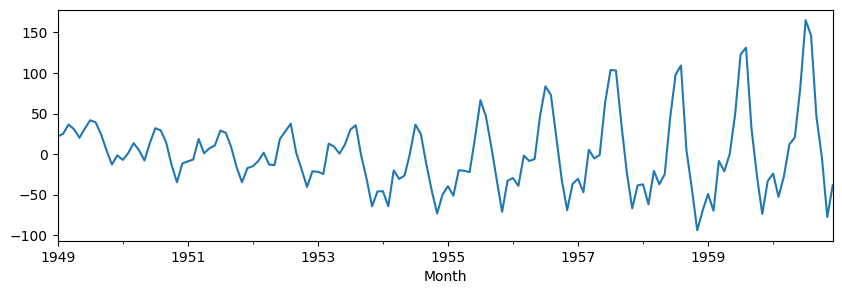

In [32]:
df["detrend - linear regression"].plot(figsize=(10, 3))

In [33]:
stationary_test(df["detrend - linear regression"])

ADF test p-value: 0.24372483602015982 stationary: False
KPSS test p-value: 0.1 stationary: True


/Users/user/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


## 계절성 제거

시계열 데이터에서 계절성만 따로 제거할 수 있습니다. 특히 계절 차분 기법은 SARIMA 모델에서 사용되는 기법입니다.

1. Timeseries Decompose: 시계열 분해에서 얻은 계절 성분을 뺍니다.
2. Seasonal Difference: 계절 차분이라고도 부릅니다. 현재 값에서 이전 시즌 값을 빼줍니다.

### timeseries decompose

In [34]:
df["deseasonal - decompose"] = df["Passengers"] / result_mul.seasonal

<Axes: xlabel='Month'>

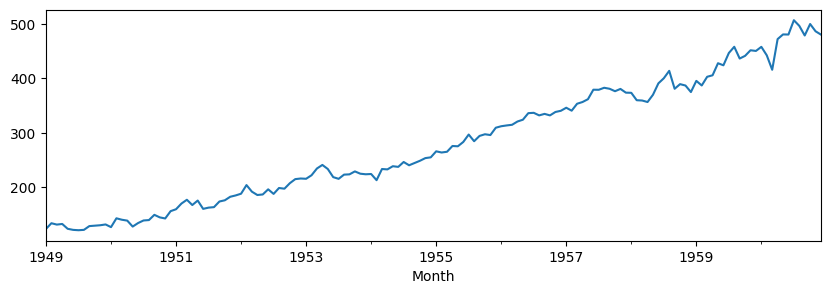

In [35]:
df["deseasonal - decompose"].plot(figsize=(10, 3))

In [36]:
stationary_test(df["deseasonal - decompose"].dropna())

ADF test p-value: 0.9955760226610061 stationary: False
KPSS test p-value: 0.01 stationary: False


/Users/user/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


### Seasonal Differencing

계절 차분은 계절성이 나타나는 데이터의 계절성을 제거해주기 위해서 사용합니다. 현재 관측치에서 이전 계절의 관측치를 빼줍니다. 위 예제에서는 12개월 주기로 계절성이 나타나므로, 계절 차분을 적용해보겠습니다.

In [39]:
df["deseasonal - diff"] = df["Passengers"].diff(12)

<Axes: xlabel='Month'>

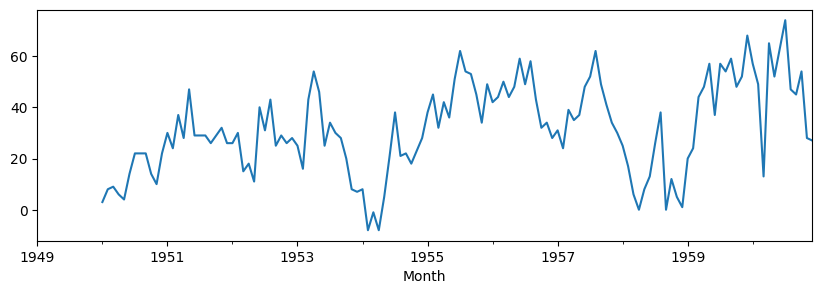

In [40]:
df["deseasonal - diff"].plot(figsize=(10, 3))

In [42]:
stationary_test(df["deseasonal - diff"].dropna())

ADF test p-value: 0.011551493085514982 stationary: True
KPSS test p-value: 0.03409999422360403 stationary: False


## 정리

이번 챕터에서는 시계열 데이터의 정상성과 비정상성에 대해서 알아보았습니다. 그리고 분석을 진행하기 이전에 non-stationary data를 stationary 데이터로 변환해주어야 하며, 이 때 적용 가능한 기법들에 대해서 배워보았습니다. 앞으로 배울 기법들에서 주로 사용되는 기법은 차분과 계절 차분이니, 이를 중심으로 복습해주시기 바랍니다.